<a href="https://colab.research.google.com/github/RatchanonPa/Data-Warehouse-and-Big-Data-Analytics/blob/main/Modellimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy import stats

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Read the CSV files
winter_data = pd.read_csv('/content/drive/MyDrive/Bigdata/taxi_data_processed1.csv')
summer_data = pd.read_csv('/content/drive/MyDrive/Bigdata/taxi_data_processed7.csv')

# Optionally, you can add a column to differentiate between winter and summer data
winter_data['season'] = 'winter'
summer_data['season'] = 'summer'

# Combine winter and summer data if needed
all_data = pd.concat([winter_data, summer_data], ignore_index=True)

In [28]:
all_data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount',
       'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'date', 'time', 'weekday', 'duration', 'day_type',
       'tip_percent', 'time_desc', 'avg_temp', 'precip', 'windspeed', 'snow',
       'snowdepth', 'PUborough', 'DOborough', 'season', 'Airport_fee'],
      dtype='object')

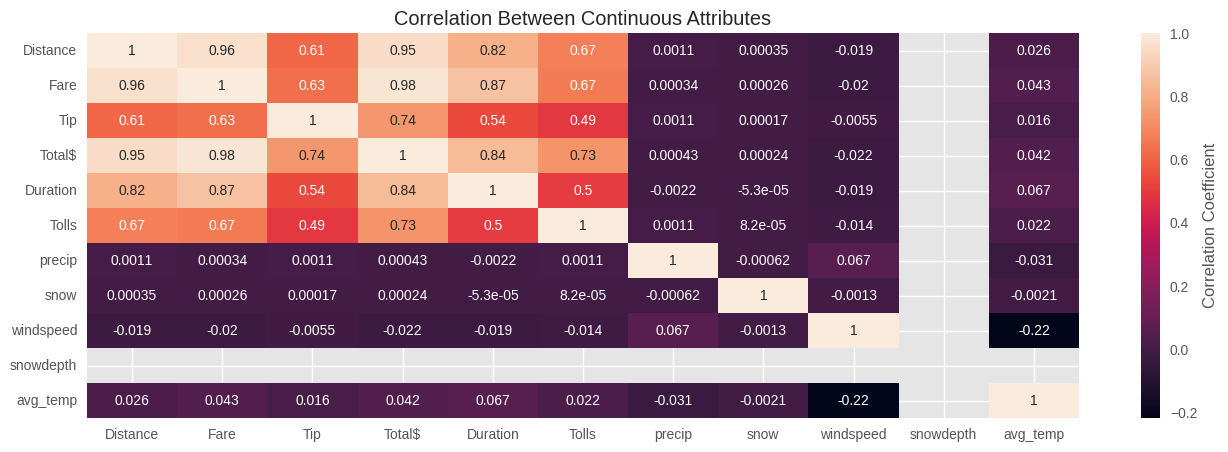

In [29]:
col = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'duration', 'tolls_amount', 'precip', 'snow', 'windspeed', 'snowdepth', 'avg_temp']
label = ['Distance', 'Fare', 'Tip', 'Total$', 'Duration', 'Tolls', 'precip', 'snow', 'windspeed', 'snowdepth', 'avg_temp']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = all_data[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

In [30]:
# keep only card payment, since tip on cash payment is not recorded

sample = all_data[all_data['payment_type'] == 1].sample(frac=0.05, replace=True, random_state=30034).reset_index(drop=True)

In [31]:
COL = ['passenger_count', 'fare_amount', 'tip_amount', 'tolls_amount',
       'season', 'day_type', 'time_desc', 'PUborough', 'DOborough']
sample_filtered = sample.loc[:, COL].reset_index(drop=True)

In [32]:
# Split data to train and test
y = sample_filtered['tip_amount']
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)

In [33]:
# Scale the continuous attributes
xCOLS = ['fare_amount', 'tolls_amount']

scaler = StandardScaler()
X_train[xCOLS] = scaler.fit_transform(X_train[xCOLS])
X_test[xCOLS] = scaler.transform(X_test[xCOLS])

In [34]:
# Baseline model which contains only the intercept

baseline = ols(formula='tip_amount ~ 1', data=X_train).fit()
print(baseline.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Oct 2024   Prob (F-statistic):                nan
Time:                        00:14:29   Log-Likelihood:            -4.2351e+05
No. Observations:              155545   AIC:                         8.470e+05
Df Residuals:                  155544   BIC:                         8.470e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2058      0.009    450.349      0.0

In [35]:

base_train_pred = baseline.predict(X_train)
base_test_pred = baseline.predict(X_test)
train_rmse = mean_squared_error(y_train, base_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, base_test_pred, squared=False)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

Train RMSE: 3.6831996746215485
Test RMSE: 3.6543197745096223


In [36]:
# fit the model
full_model = ols(formula='tip_amount ~ C(passenger_count) + fare_amount + tolls_amount + season + time_desc + day_type + PUborough + DOborough', data=X_train).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 1.157e+04
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:14:33   Log-Likelihood:            -3.4385e+05
No. Observations:              155545   AIC:                         6.878e+05
Df Residuals:                  155520   BIC:                         6.880e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [37]:
# predict and evaluate
full_train_pred = full_model.predict(X_train)
full_test_pred = full_model.predict(X_test)
train_rmse = mean_squared_error(y_train, full_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, full_test_pred, squared=False)
train_r2 = r2_score(y_train, full_train_pred)
test_r2 = r2_score(y_test, full_test_pred)

print("Full model")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2", train_r2)
print("Test R2", test_r2)

Full model
Train RMSE: 2.207140650692435
Test RMSE: 2.159246787327538
Train R2 0.6409048892765822
Test R2 0.6508657338675623


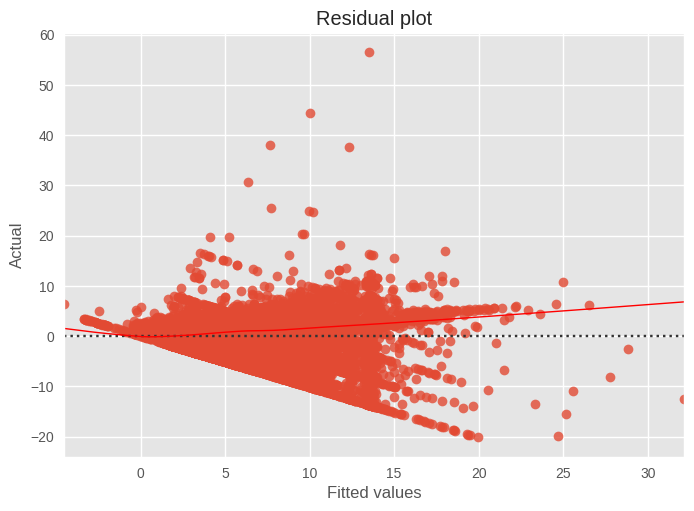

In [38]:
!pip install seaborn
!pip install statsmodels
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'full_test_pred' and 'y_test' are NumPy arrays or pandas Series
# Create a DataFrame for residplot
residual_data = {'Predicted': full_test_pred, 'Actual': y_test}
residual_df = pd.DataFrame(residual_data)

sns.residplot(x='Predicted', y='Actual', data=residual_df, lowess=True, line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')
plt.show()

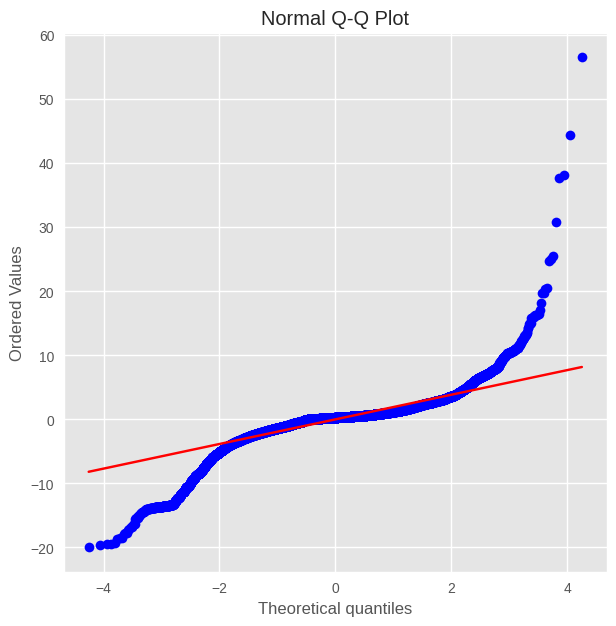

In [39]:
residuals = y_test - full_test_pred

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

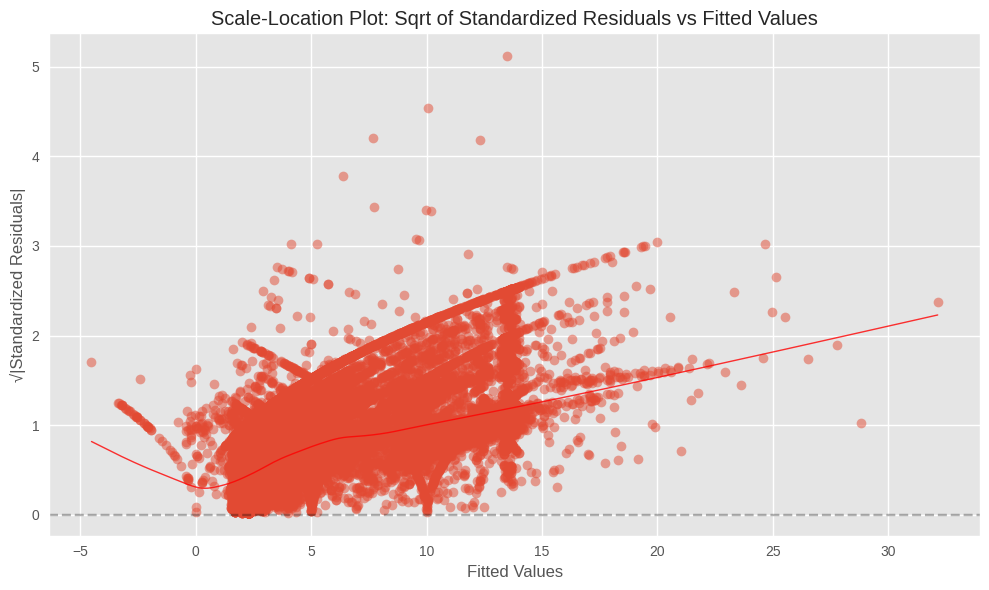

In [40]:
# Calculate standardized residuals manually
residuals = y_test - full_test_pred
std_residuals = residuals / np.std(residuals)
std_residuals_abs_sqrt = np.sqrt(np.abs(std_residuals))

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Fitted': full_test_pred,
    'Residuals': std_residuals_abs_sqrt
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.regplot(x='Fitted',
            y='Residuals',
            data=plot_data,
            scatter=True,
            scatter_kws={'alpha':0.5},
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Customize the plot
plt.title('Scale-Location Plot: Sqrt of Standardized Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

## Gradient Boost Regression

In [41]:
# convert categorical data to dummy variable

sample_filtered = pd.get_dummies(sample_filtered, drop_first=True)

In [42]:
# train test split the sampled data

y = sample_filtered['tip_amount']
sample_filtered = sample_filtered.drop(['tip_amount'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(sample_filtered, y, test_size=0.3, random_state=0)

In [43]:
sample_filtered

,fare_amount,tolls_amount,passenger_count_medium,passenger_count_small,season_winter,day_type_weekend,day_type_workday,time_desc_Evening,time_desc_Late Night,time_desc_Morning,...,PUborough_Manhattan,PUborough_Queens,PUborough_Staten Island,DOborough_Brooklyn,DOborough_EWR,DOborough_JFK,DOborough_LaGuardia,DOborough_Manhattan,DOborough_Queens,DOborough_Staten Island
0,14.2,0.0,False,True,True,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
1,24.7,0.0,False,True,False,False,True,False,False,True,...,True,False,False,False,False,False,False,True,False,False
2,10.0,0.0,False,True,True,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
3,12.1,0.0,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,21.9,0.0,False,True,False,False,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222203,4.4,0.0,False,True,False,True,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
222204,10.7,0.0,False,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
222205,9.3,0.0,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,True,False,False
222206,10.0,0.0,False,True,True,False,True,True,False,False,...,True,False,False,False,False,False,False,True,False,False


In [44]:
# Convert categorical data to numerical using one-hot encoding
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'X_train' is your training data
# Assuming 'categorical_features' contains the list of column names with categorical data

# Get the list of categorical columns that actually exist in X_train
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# If any of the desired columns are missing, print a warning
desired_columns = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'payment_type']
missing_columns = [col for col in desired_columns if col not in categorical_features]
if missing_columns:
    print(f"Warning: The following columns are missing from X_train: {missing_columns}")

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output

# Fit the encoder to the existing categorical columns in the training data
encoder.fit(X_train.loc[:, categorical_features])

# Transform the categorical features in both training and test data
encoded_features_train = encoder.transform(X_train.loc[:, categorical_features])
encoded_features_test = encoder.transform(X_test.loc[:, categorical_features])

# Get feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

NameError: name 'reg' is not defined

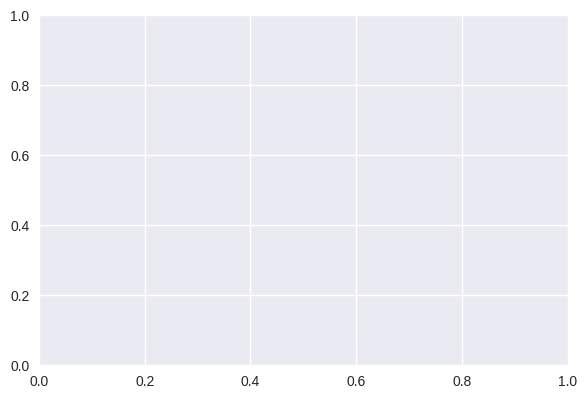

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have these variables from your previous code:
# X_train, X_test, y_train, y_test, sample_filtered, gbr_train_pred, gbr_test_pred
# reg (your trained GradientBoostingRegressor)
# train_rmse, test_rmse, train_r2, test_r2

# Create figure with subplots
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Feature Importance Plot
ax1 = fig.add_subplot(gs[0, 0])
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': reg.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df_plot = importance_df.tail(10)  # Top 10 features

sns.barh(y='feature', x='importance', data=importance_df_plot, ax=ax1)
ax1.set_title('Top 10 Feature Importance')
ax1.set_xlabel('Importance Score')

# 2. Predicted vs Actual Plot
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(gbr_test_pred, y_test, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Tips')
ax2.set_ylabel('Actual Tips')
ax2.set_title('Predicted vs Actual Tips')

# 3. Residuals Plot
ax3 = fig.add_subplot(gs[1, 0])
residuals = y_test - gbr_test_pred
sns.histplot(residuals, kde=True, ax=ax3)
ax3.set_title('Distribution of Residuals')
ax3.set_xlabel('Residual Value')

# 4. Model Performance Metrics
ax4 = fig.add_subplot(gs[1, 1])
metrics = {
    'Metric': ['Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [train_rmse, test_rmse, train_r2, test_r2]
}
ax4.axis('off')
metrics_table = ax4.table(cellText=[[f'{k}: {v:.4f}'] for k, v in zip(metrics['Metric'], metrics['Value'])],
                         loc='center', cellLoc='center', bbox=[0.1, 0.3, 0.8, 0.5])
metrics_table.auto_set_font_size(False)
metrics_table.set_fontsize(9)
metrics_table.scale(1.5, 2)
ax4.set_title('Model Performance Metrics', pad=20)

plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nTop 5 Most Important Features:")
print("------------------------------")
for _, row in importance_df.tail(5).iloc[::-1].iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [ ]:
# Convert categorical data to numerical using one-hot encoding
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'X_train' is your training data
# Assuming 'categorical_features' contains the list of column names with categorical data

# Get the list of categorical columns that actually exist in X_train
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# If any of the desired columns are missing, print a warning
desired_columns = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'payment_type']
missing_columns = [col for col in desired_columns if col not in categorical_features]
if missing_columns:
    print(f"Warning: The following columns are missing from X_train: {missing_columns}")

# Create a OneHotEncoder object with handle_

In [ ]:
# Convert categorical data to numerical using one-hot encoding
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming 'X_train' is your training data
# Assuming 'categorical_features' contains the list of column names with categorical data

# Get the list of categorical columns that actually exist in X_train
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# If any of the desired columns are missing, print a warning
desired_columns = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'store_and_fwd_flag', 'payment_type']
missing_columns = [col for col in desired_columns if col not in categorical_features]
if missing_columns:
    print(f"Warning: The following columns are missing from X_train: {missing_columns}")

# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for dense output

# Fit the encoder to the existing categorical columns in the training data
encoder.fit(X_train.loc[:, categorical_features])

# Transform the categorical features in both training and test data
encoded_features_train = encoder.transform(X_train.loc[:, categorical_features])
encoded_features_test = encoder.transform(X_test.loc[:, categorical_features])

# Get feature names after one-hot encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create DataFrames from the encoded features
encoded_features_train_df = pd.DataFrame(encoded_features_train, columns=encoded_feature_names, index=X_train.index)
encoded_features_test_df = pd.DataFrame(encoded_features_test, columns=encoded_feature_names, index=X_test.index)

# Drop original categorical columns and concatenate encoded features
X_train = X_train.drop(columns=categorical_features)
X_train = pd.concat([X_train, encoded_features_train_df], axis=1)

X_test = X_test.drop(columns=categorical_features)
X_test = pd.concat([X_test, encoded_features_test_df], axis=1)

In [ ]:
all_data.info()